# Actividad Módulo 26: Introducción a Machine Learning Parte 2
- Importación del archivo de uso (bank-additional-full.csv)
- Feature Engineering (https://towardsdatascience.com/how-and-why-to-standardize-your-data-996926c2c832):
    - Variables de alto sesgo
    - Estandarización de variables
- Eliminar variables con alta correlación o variables no necesarias
- Generar test de training y testing (70% - 30%)
- Modelo simple de regresión logística
- Matriz de confusión y conclusiones del modelo
- Cálculo de las primeras medidas de calidad del modelo: Accuracy, Precision, Recall, F1, ROC
- Conclusiones

Standardization vs Normalization of data: https://towardsdatascience.com/standardization-vs-normalization-dc81f23085e3

In [97]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [98]:
df = pd.read_csv('D:/Documentos/Documentos/DataAnalysis/ebac/Python/Modulo25/bank-additional-full.csv', sep=';')
df.sample(5)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
15217,56,admin.,divorced,basic.6y,no,no,no,cellular,jul,thu,...,5,999,0,nonexistent,1.4,93.918,-42.7,4.958,5228.1,no
27785,39,admin.,single,high.school,no,yes,no,cellular,mar,tue,...,2,999,0,nonexistent,-1.8,92.843,-50.0,1.687,5099.1,no
12981,38,admin.,married,university.degree,no,yes,yes,cellular,jul,tue,...,3,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no
38786,32,self-employed,married,university.degree,no,yes,no,cellular,nov,thu,...,1,6,3,failure,-3.4,92.649,-30.1,0.714,5017.5,yes
23537,37,admin.,single,university.degree,no,no,no,cellular,aug,thu,...,2,999,0,nonexistent,1.4,93.444,-36.1,4.962,5228.1,no


In [99]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [100]:
# 1. Imputación de datos
# Determinar si es necesaria la imputación de datos en caso de que haya campos vacíos o nulos
print('Cuenta de campos nulos por variable')
df.isnull().sum()

Cuenta de campos nulos por variable


age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

C:\Users\USER\AppData\Local\Temp\ipykernel_3124\1786607000.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr(method='pearson')


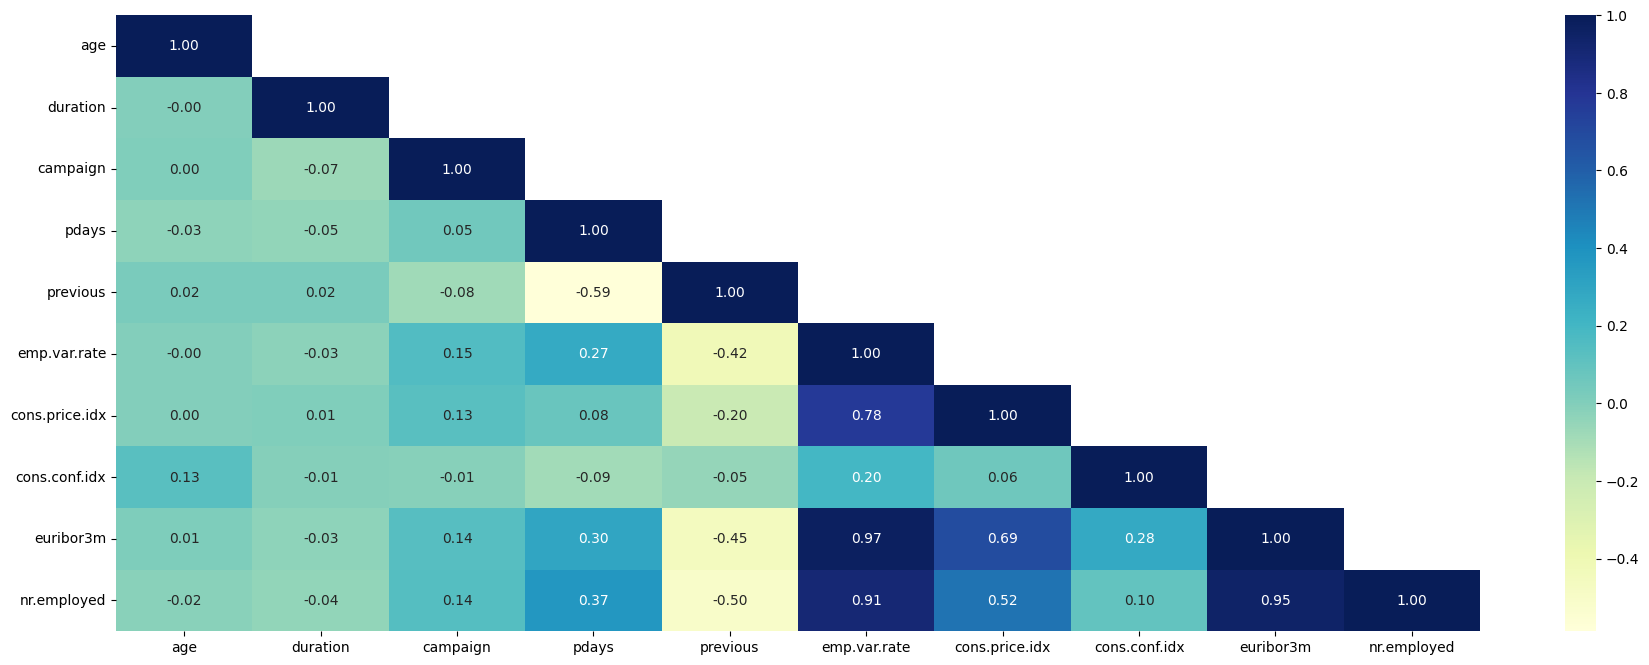

In [101]:
# Eliminar variables con alta correlación y variables innecesarias
plt.figure(figsize=(22,8))
corr = df.corr(method='pearson')
df_lt = corr.where(np.tril(np.ones(corr.shape)).astype(bool))
hmap  = sns.heatmap(data=df_lt, annot=True, cmap='YlGnBu', fmt='.2f')

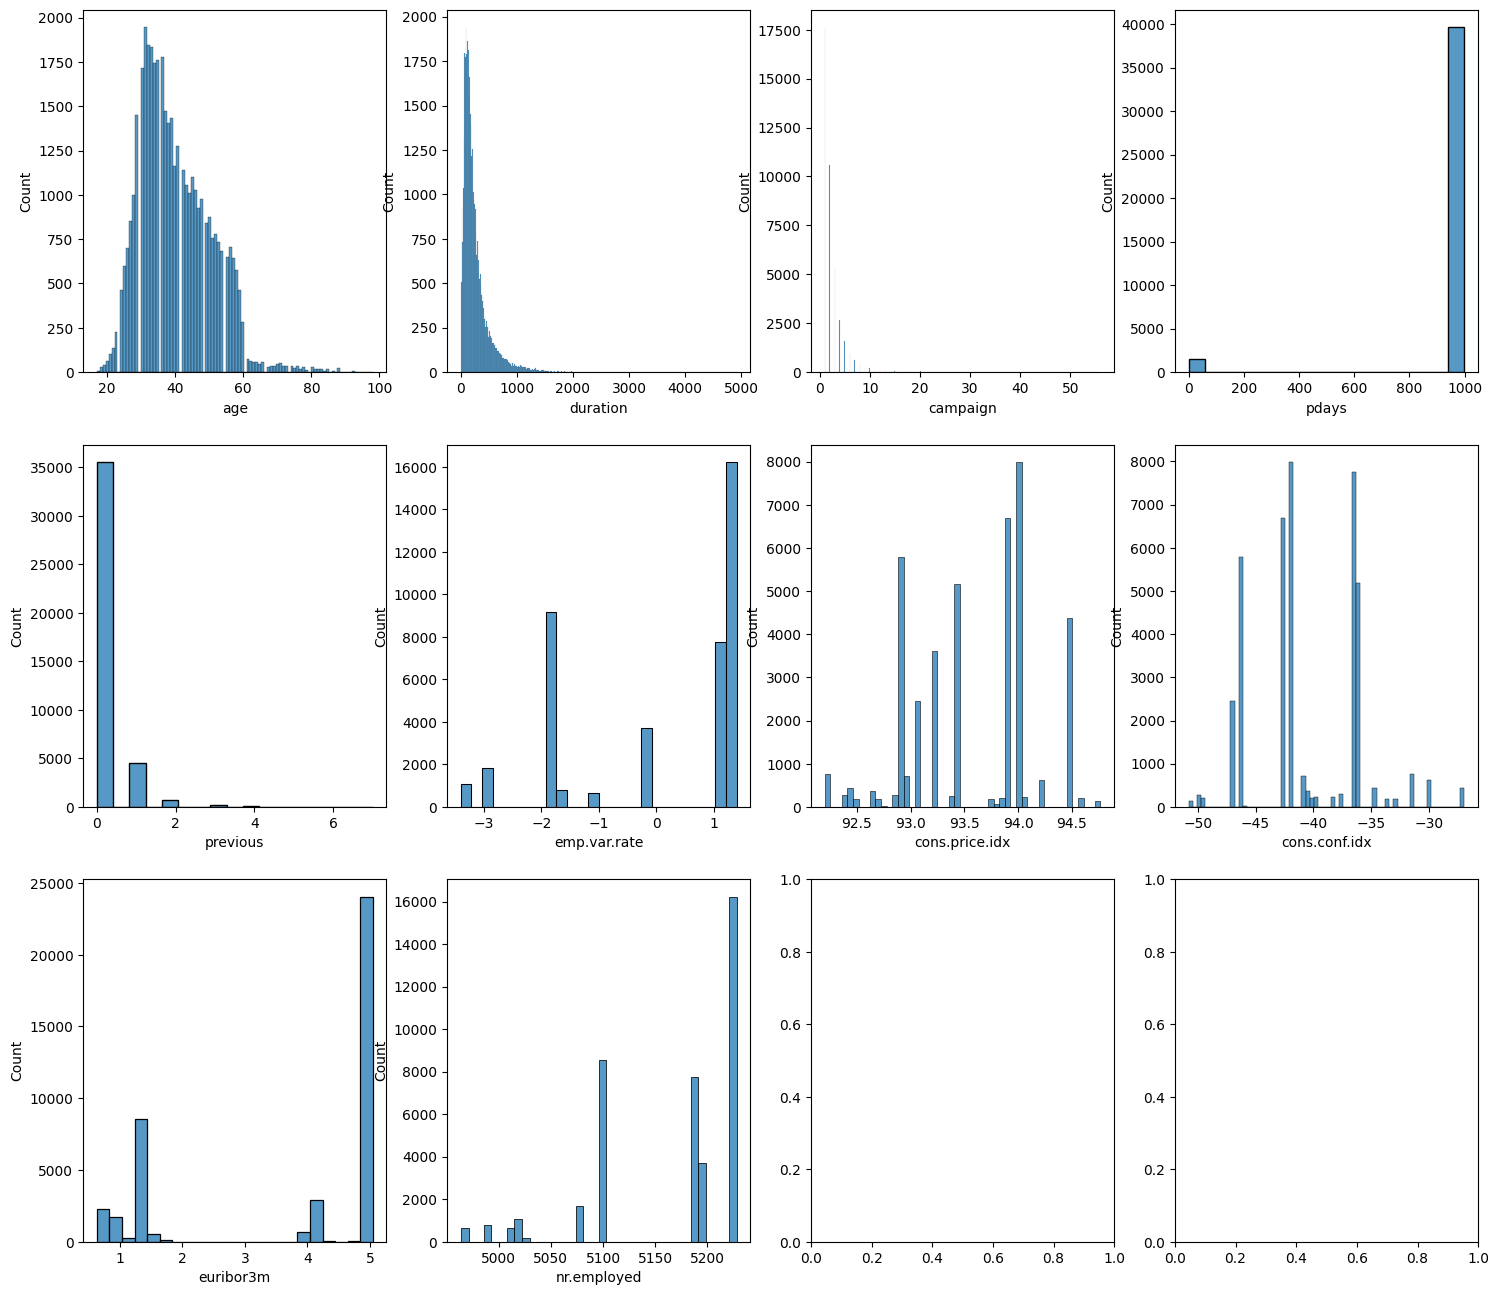

In [102]:
# 2. Análisis univariado - variables numéricas
# Graficar la distribución de las variables numéricas que presenta el dataset para poder identificar aquellas que presenten un alto sesgo

numeric_columns = []

for column in df.columns:
    if df[column].dtype != 'object':
        numeric_columns.append(column)

fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(18,16))
for i, column in enumerate(numeric_columns):
    sns.histplot(data=df, x=column, ax=ax[i//4, i%4])


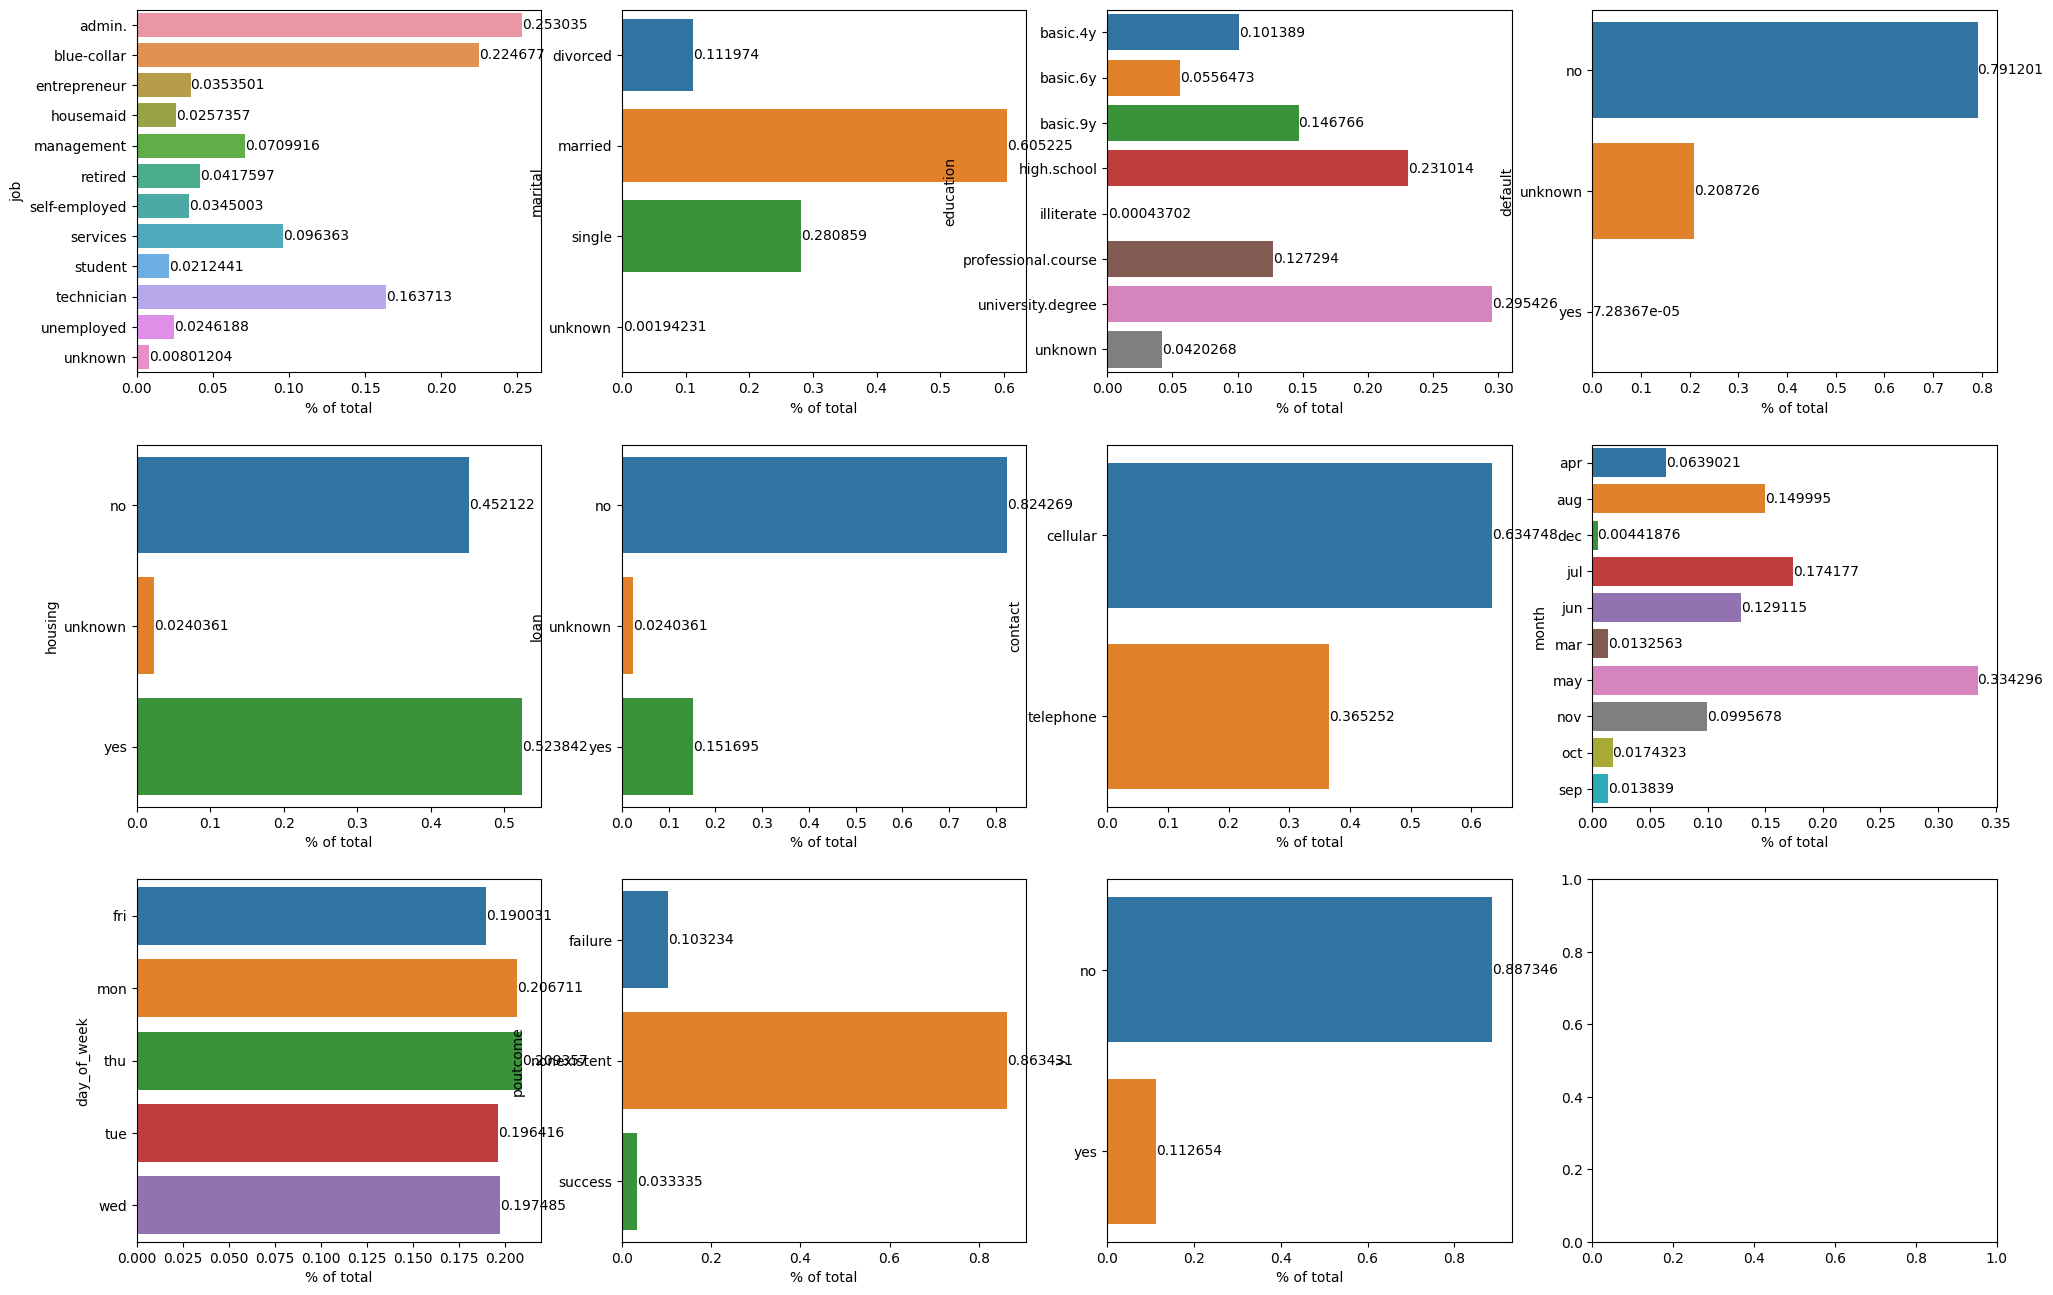

In [103]:
# 2. Análisis univariado - variables categóricas

categorical_columns = []

for column in df.columns:
    if df[column].dtype == 'object':
        categorical_columns.append(column)

fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(24,16))
for i, column in enumerate(categorical_columns):
    pivot = df.groupby(by=[column]).count()['age'].reset_index()
    pivot['age'] = pivot['age'] / np.sum(pivot['age'])
    pivot.style.format(formatter={'age':'{:.2%}'})
    fig = sns.barplot(data=pivot.rename(columns={'age': '% of total'}), x='% of total', y=column, ax=ax[i//4, i%4])
    for i in fig.containers:
        fig.bar_label(i,)


### Insights:
- Las variables numéricas tienen, en general, mucho sesgo por lo que se tendrán que normalizar
- Algunas de las varaibles categórcias tienen clases desbalanceadas (representando menos del 5% de los registros)
    - Algunas de estas clases son la categoría unknown en todas las variables que aparece y otros grupos más puntuales
    - Será necesario juntar categorías en más de una variable bajo el concepto "Otros" para poder obtener una 


d:\Programas\Python311\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
d:\Programas\Python311\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


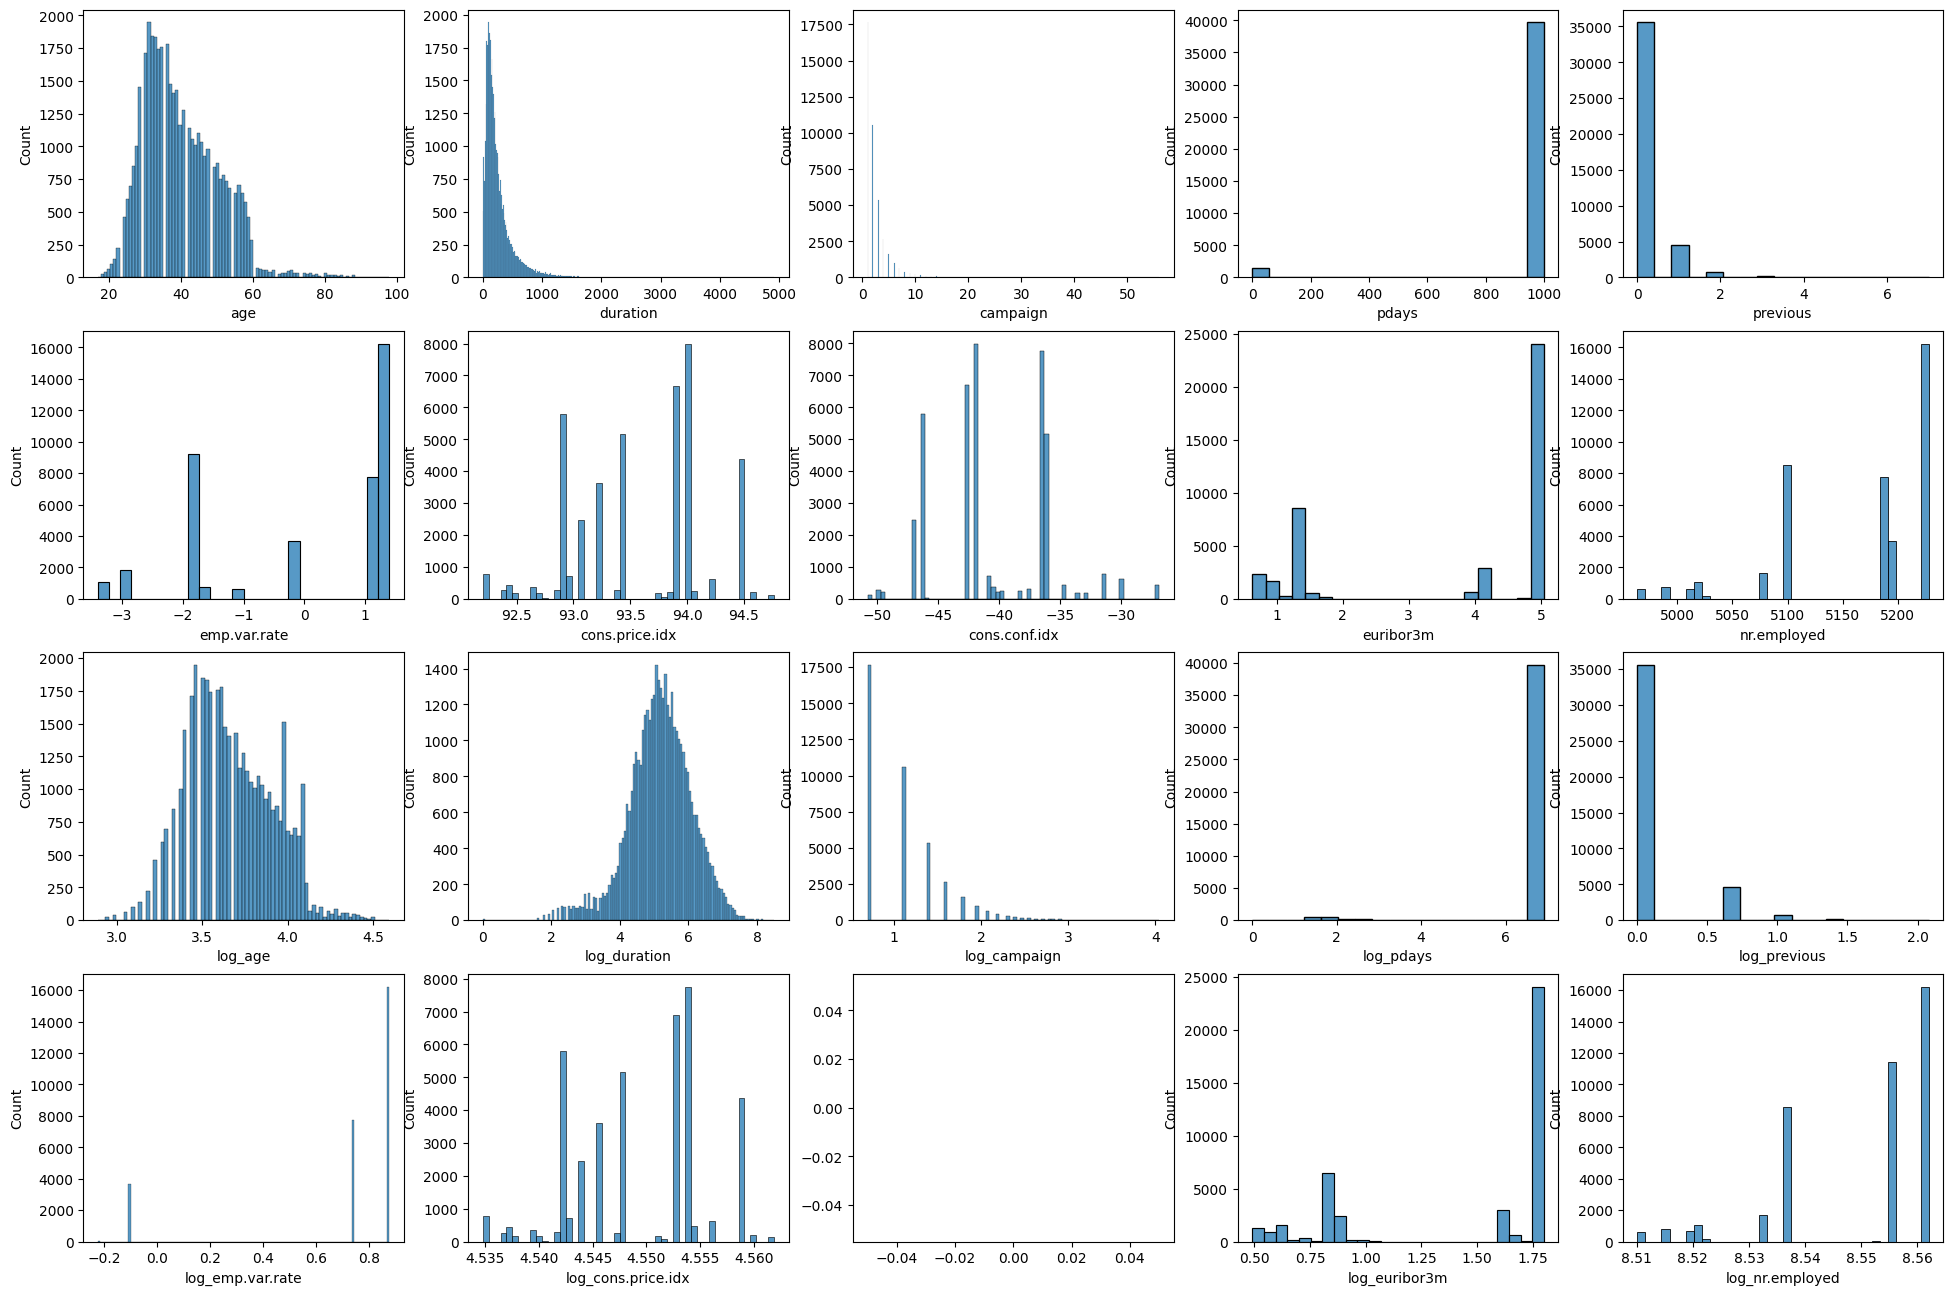

In [104]:
# Normalizar variables con sesgo

for column in numeric_columns:
    df['log_'+column] = np.log(df[column] + 1)

numeric_columns = []
for column in df.columns:
    if df[column].dtype != 'object':
        numeric_columns.append(column)

fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(24,16))
for i, column in enumerate(numeric_columns):
    sns.histplot(data=df, x=column, kde=False, ax=ax[i//5, i%5])


# La estandarización de variables usando StandardScaler no es necesario puesto que al transformar las variables con logaritmo natural

In [105]:
# Agrupar clases desbalanceadas por variable categórica
# Variable job
df['job'] = df['job'].apply(lambda x : 'other' if  x in ['entrepreneur', 'self-employed', 'housemaid', 'retired', 'student', 'unemployed', 'unknown'] else x)

# Variable education
df['eduation'] = df['education'].apply(lambda x : 'other' if  x in ['unknown', 'illiterate'] else x)

# El resto de las variables no tienen más de un grupo subrepresentado que se puedan juntar bajo un mismo concepto "Other"
